In [ ]:
## Uncomment if in Google Colab

# !pip install kaleido

# !pip install plotly>=4.0.0
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import scipy.io
import os
import numpy as np
from sklearn.model_selection import train_test_split
import time
import math

from collections import defaultdict
import plotly.graph_objects as go
from tqdm import tqdm
from IPython.display import Image


# Exploratory Data Analysis

In [2]:
def reset_random_seeds(seed=1):
    '''
    Sets all necessary seed for reproduceability.
    '''
    os.environ['PYTHONHASHSEED']=str(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

reset_random_seeds()

In [3]:
FILE_PATH = '../../data/'

# Open table of column names text file, get the column names
f = open(FILE_PATH+'col_names.txt')
cols = f.read()
cols = [' '.join(c.split()[1:]) for c in cols.split('\n')] + ['LABEL']

# Read dataset and convert to dataframe
data = scipy.io.loadmat(FILE_PATH+'OQC.mat')
df = pd.DataFrame(data['data'], columns=cols)
# Shuffle pandas dataframe
df = df.sample(frac=1, random_state=1).reset_index(drop=True)

print("Unique labels:", df['LABEL'].unique())
df.head()

Unique labels: [1. 0. 2.]


,"SCREW VOLUME, ACTUAL VALUE","MATERIAL CUSHION, ACTUAL VALUE","DOSAGE TIME, ACTUAL VALUE","CYCLE TIME, ACTUAL VALUE","MOULD HEATING CIRCUIT 1, ACTUAL VALUE","MOULD HEATING CIRCUIT 2, ACTUAL VALUE","MOULD HEATING CIRCUIT 3, ACTUAL VALUE","MOULD HEATING CIRCUIT 4, ACTUAL VALUE","MOULD HEATING CIRCUIT 5, ACTUAL VALUE","MOULD HEATING CIRCUIT 6, ACTUAL VALUE",...,"DOSAGE TORQUE, ACTUAL VALUE","DOSAGE ROTATIONAL SPEED, ACTUAL VALUE","HYDRAULIC ACCUMULATOR PRESSURE, ACTUAL VALUE","CHARGE PRESSURE OF ACCUMULATOR, MEASURED VALUE","MOULD-ENTRY TIME, ACTUAL VALUE","PART REMOVAL TIME, ACTUAL VALUE","MAXIMUM INJECTION PRESSURE, ACTUAL VALUE","BACK PRESSURE, ACTUAL","CLAMPING FORCE, ACTUAL",LABEL
0,0.267648,0.080815,0.620853,0.000113,0.666667,0.666667,0.666667,0.714286,0.50,0.785714,...,0.682513,0.037255,0.032894,0.0,0.000000,0.000,0.196721,0.196721,0.925926,1.0
1,1.000000,0.121951,0.772512,0.001732,0.222222,0.333333,0.222222,0.428571,0.25,0.500000,...,0.696095,0.037255,0.166076,1.0,0.000038,0.125,0.026042,0.026042,0.006914,1.0
2,0.473009,0.065162,0.819905,0.000113,0.666667,0.444444,0.444444,0.857143,0.50,0.214286,...,0.879457,0.994118,0.595073,0.0,0.000075,0.250,0.057892,0.056674,0.927901,0.0
3,1.000000,0.106662,0.535545,0.001016,0.333333,0.333333,0.333333,0.285714,0.50,0.785714,...,0.707980,0.037255,0.483439,1.0,0.000113,0.375,0.025761,0.025761,0.013333,1.0
4,0.300113,0.030579,0.649289,0.002409,0.666667,0.888889,0.555556,1.000000,0.25,0.500000,...,0.772496,0.052941,0.680918,1.0,0.000038,0.125,0.058361,0.058361,0.912099,0.0


In [4]:
# Find if there are any duplicated rows. If there are, make sure they dont belong in both
# train and test set.
duplicated_idx = [i for i,k in enumerate(df.duplicated()) if k]
df.iloc[duplicated_idx]

,"SCREW VOLUME, ACTUAL VALUE","MATERIAL CUSHION, ACTUAL VALUE","DOSAGE TIME, ACTUAL VALUE","CYCLE TIME, ACTUAL VALUE","MOULD HEATING CIRCUIT 1, ACTUAL VALUE","MOULD HEATING CIRCUIT 2, ACTUAL VALUE","MOULD HEATING CIRCUIT 3, ACTUAL VALUE","MOULD HEATING CIRCUIT 4, ACTUAL VALUE","MOULD HEATING CIRCUIT 5, ACTUAL VALUE","MOULD HEATING CIRCUIT 6, ACTUAL VALUE",...,"DOSAGE TORQUE, ACTUAL VALUE","DOSAGE ROTATIONAL SPEED, ACTUAL VALUE","HYDRAULIC ACCUMULATOR PRESSURE, ACTUAL VALUE","CHARGE PRESSURE OF ACCUMULATOR, MEASURED VALUE","MOULD-ENTRY TIME, ACTUAL VALUE","PART REMOVAL TIME, ACTUAL VALUE","MAXIMUM INJECTION PRESSURE, ACTUAL VALUE","BACK PRESSURE, ACTUAL","CLAMPING FORCE, ACTUAL",LABEL


In [5]:
# Input shape
np.array(df.iloc[0]).shape

(49,)

In [6]:
device= torch.device("cuda")
# device= torch.device("cpu")
print(device)

cuda


In [7]:
# Count number of each classes. If heavily inbalanced we need to do stratified split. Otherwise
# just splitting by index should be fine.
print(df['LABEL'].value_counts())
Y = df.iloc[:, -1:]
X = df.iloc[:, :-1]
# Train test split with stratification sampling
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1, shuffle=True, stratify=Y)

# convert to torch tensors with relevant dtypes.
train_data = torch.tensor(x_train.values).type('torch.cuda.DoubleTensor')
test_data = torch.tensor(x_test.values).type('torch.cuda.DoubleTensor')

train_label = torch.tensor(y_train.values).type('torch.cuda.LongTensor').reshape(len(y_train))
test_label = torch.tensor(y_test.values).type('torch.cuda.LongTensor').reshape(len(y_test))

1.0    1074
0.0    1008
2.0     870
Name: LABEL, dtype: int64


In [8]:
print("Train Labels Distributions: ", y_train.value_counts())
print("Test Labels Distribution: ", y_test.value_counts())

Train Labels Distributions:  LABEL
1.0      752
0.0      705
2.0      609
dtype: int64
Test Labels Distribution:  LABEL
1.0      322
0.0      303
2.0      261
dtype: int64


# Functions

In [9]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs  

In [10]:
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('There are {} ({:.2f} million) parameters in this neural network'.format(
        nb_param, nb_param/1e6)
         )

In [11]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size1, bias=False)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2, bias=False)
        self.layer3 = nn.Linear(hidden_size2, output_size, bias=False)        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = F.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

In [12]:
class twelve_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size,  output_size):
        super(twelve_layer_net , self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size[0], bias=False)
        self.layer2 = nn.Linear(hidden_size[0], hidden_size[1], bias=False)
        self.layer3 = nn.Linear(hidden_size[1], hidden_size[2], bias=False)   

        self.layer4 = nn.Linear(hidden_size[2], hidden_size[3], bias=False)
        self.layer5 = nn.Linear(hidden_size[3], hidden_size[4], bias=False)
        self.layer6 = nn.Linear(hidden_size[4], hidden_size[5], bias=False)    

        self.layer7 = nn.Linear(hidden_size[5], hidden_size[6], bias=False)
        self.layer8 = nn.Linear(hidden_size[6], hidden_size[7], bias=False)
        self.layer9 = nn.Linear(hidden_size[7], hidden_size[8], bias=False)  

        self.layer10 = nn.Linear(hidden_size[8], hidden_size[9], bias=False)
        self.layer11 = nn.Linear(hidden_size[9], hidden_size[10], bias=False)
        self.layer12 = nn.Linear(hidden_size[10], output_size, bias=False)

    def forward(self, x):
        y1       = self.layer1(x)
        y_hat1   = F.relu(y1)

        y2       = self.layer2(y_hat1)
        y_hat2   = F.relu(y2)

        y3       = self.layer3(y_hat2)
        y_hat3   = F.relu(y3)

        y4       = self.layer4(y_hat3)
        y_hat4   = F.relu(y4)

        y5       = self.layer5(y_hat4)
        y_hat5   = F.relu(y5)

        y6       = self.layer6(y_hat5)
        y_hat6   = F.relu(y6)

        y7       = self.layer7(y_hat6)
        y_hat7   = F.relu(y7)

        y8       = self.layer8(y_hat7)
        y_hat8   = F.relu(y8)

        y9       = self.layer9(y_hat8)
        y_hat9   = F.relu(y9)

        y10       = self.layer10(y_hat9)
        y_hat10   = F.relu(y10)

        y11       = self.layer11(y_hat10)
        y_hat11   = F.relu(y11)

        scores  = self.layer12(y_hat11)
        
        return scores

In [14]:
def eval(model, batch_size, trainable, lr):
    '''
    Function for evaluating a model. If trainable=True we will update the weights.
    '''
    running_error = 0
    running_loss = 0

    data_size = len(train_data) if trainable else len(test_data)
    data = train_data if trainable else test_data
    label = train_label if trainable else test_label

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for num_batches, count in enumerate(range(math.ceil(data_size/batch_size))):
        if trainable:
            # Set the gradients to zeros
            optimizer.zero_grad()
        
        # Get minibatch data
        minibatch_data = data[count*bs:(count+1)*bs]
        minibatch_label = label[count*bs:(count+1)*bs]

        # Load data to GPU
        minibatch_data = minibatch_data.to(device)
        minibatch_label = minibatch_label.to(device)

        # Record gradients on forward pass if we are training
        if trainable:
            minibatch_data.requires_grad_()
        
        # Pass the data through the model
        scores = model(minibatch_data.float())

        # Compute loss and error
        loss = criterion(scores, minibatch_label)
        

        # Perform backward pass if we are training
        if trainable:
            loss.backward()
            optimizer.step()
            
        error = get_error(scores.detach(), minibatch_label)
        running_loss += loss.detach().item()
        running_error += error.item()

    # Compute loss, error and time taken for this epoch
    total_loss = running_loss/(num_batches+1)
    total_error = running_error/(num_batches+1)

    return total_loss, total_error


In [15]:
def fit(model, batch_size, num_epochs, lr, decay, verbose=0):

    history = defaultdict(list)
    for epoch in range(1, num_epochs+1):
        start = time.time()
        train_loss, train_error = eval(model, batch_size, trainable=True, lr=lr)
        test_loss, test_error = eval(model, batch_size, trainable=False, lr=lr)

        history['train_error'].append(train_error)
        history['train_loss'].append(train_loss)
        history['test_error'].append(test_error)
        history['test_loss'].append(test_loss)
        history['time'].append(time.time()-start)

        if verbose:
            if epoch%verbose==0:
                print(f" Epoch {epoch}, Training Error: {train_error}, Training Loss: {train_loss}, Test Error: {test_error}, Test Loss: {test_loss}, Time Elapsed: {time.time()-start}")

        lr = lr * decay

    return history


In [24]:
def plot_line(title, y_axis_name, x_axis_name, decimal=False, **kwargs):
    '''
    Helper function for plotting line charts in Plotly
    '''
    fig = go.Figure()
    colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']
    for i, (name, x) in enumerate(kwargs.items()):
        if not decimal:
            # Create traces
            fig.add_trace(go.Scatter(y=x,
                                line=dict(color=colors[i]),
                                mode='lines',
                                name=' '.join(name.split('_'))))
            fig.add_trace(go.Scatter(line=dict(color=colors[i]), 
                                    y=[min(x)], 
                                    x=[x.index(min(x))], 
                                    text=[str(x.index(min(x))+1)],
                                    textposition="top center",
                                    mode='markers+text', 
                                    name='Min. Point '+' '.join(name.split('_')), marker=dict(size=[10])))
        else:
            # Create traces
            fig.add_trace(go.Scatter(y=x,
                                line=dict(color=colors[i]),
                                mode='lines',
                                name='.'.join(name.split('_'))))
            fig.add_trace(go.Scatter(y=[min(x)], 
                                    line=dict(color=colors[i]),
                                    x=[x.index(min(x))], 
                                    text=[str(x.index(min(x))+1)],
                                    textposition="top center",
                                    mode='markers+text', 
                                    name='Min. Point '+'.'.join(name.split('_')), marker=dict(size=[10])))
    fig.update_layout(title=title,
                   xaxis_title=x_axis_name,
                   yaxis_title=y_axis_name)
    return fig

# Task 1

Task 1 requires the following criterias to be met:
* 3-Layer Feed-Forward Neural Network
* Individual selection of number of nodes in hidden layers, number of epochs, learning rates and mini-batch size.
* SGD optimizer
* Minimize the testing classification error (i.e. Accuracy)
* No feature selection

For this task, we used the following hyper parameters.
1. 3-Layer Neural Network
2. 500 nodes per hidden layer
3. Cross Entropy Loss
4. 1000 epochs
5. Learning rate of 0.01 with no regularization or decay
6. Batch size 200

In [25]:
# Create network
task1_network = three_layer_net(48,500,500,3)
task1_network = task1_network.to(device)

display_num_param(task1_network)
print(task1_network)

criterion = nn.CrossEntropyLoss()

bs = 200

# Train the model
history = fit(task1_network, bs, num_epochs=1000, lr=0.01, decay=1, verbose=20)


# Create plotly graphs, convert to static images for html visibility
fig1 = plot_line('Task 1 Train/Test Errors', 'Error', 'Epochs', Train_Error=history['train_error'], Test_Error=history['test_error'])
fig2 = plot_line('Task 1 Train/Test Loss', 'Loss', 'Epochs', Train_Loss=history['train_loss'], Test_Loss=history['test_loss'])

# fig1.show(), fig2.show()
image_bytes = fig1.to_image(format='png', width=1200, height=700, scale=1) 
image_bytes2 = fig2.to_image(format='png', width=1200, height=700, scale=1)


Based on the graphs below we can determine the following information.

Firstly, the minimum test set error we got was 0.0% - in other words, we achieved a 100% accuracy. This is a particularly unusual occurrence in my experience. As such, I did some investigation which will be explained later.

Secondly, while accuracy has hit 100% for both training and testing  sets, the loss continued to decrease such that the minimum accumulated loss for both is at Epoch 1000 (i.e. the final epoch of training). This implies that the model has not overfit and is continuing to learn how to more accurately classify each class. 

Both observations leads to the conclusion that the given dataset has been tuned to be extremely easy to predict, much like the popular 'Titanic Dataset' which can achieve a 100% accuracy as well.

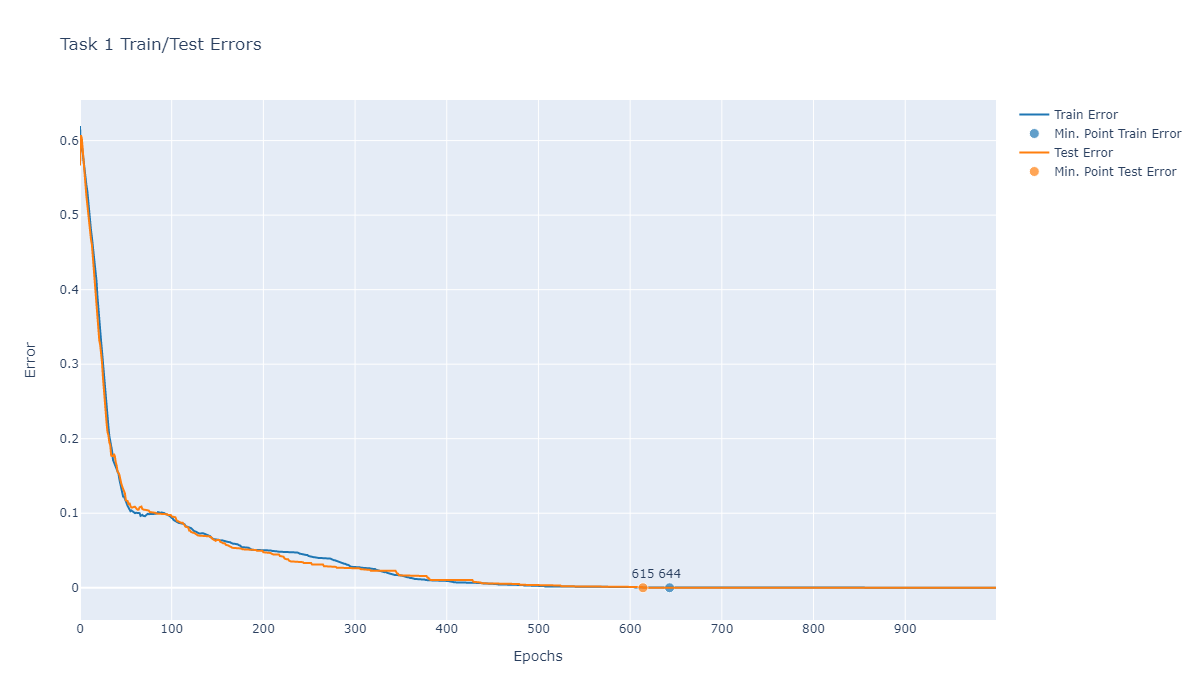

In [26]:
Image(image_bytes)

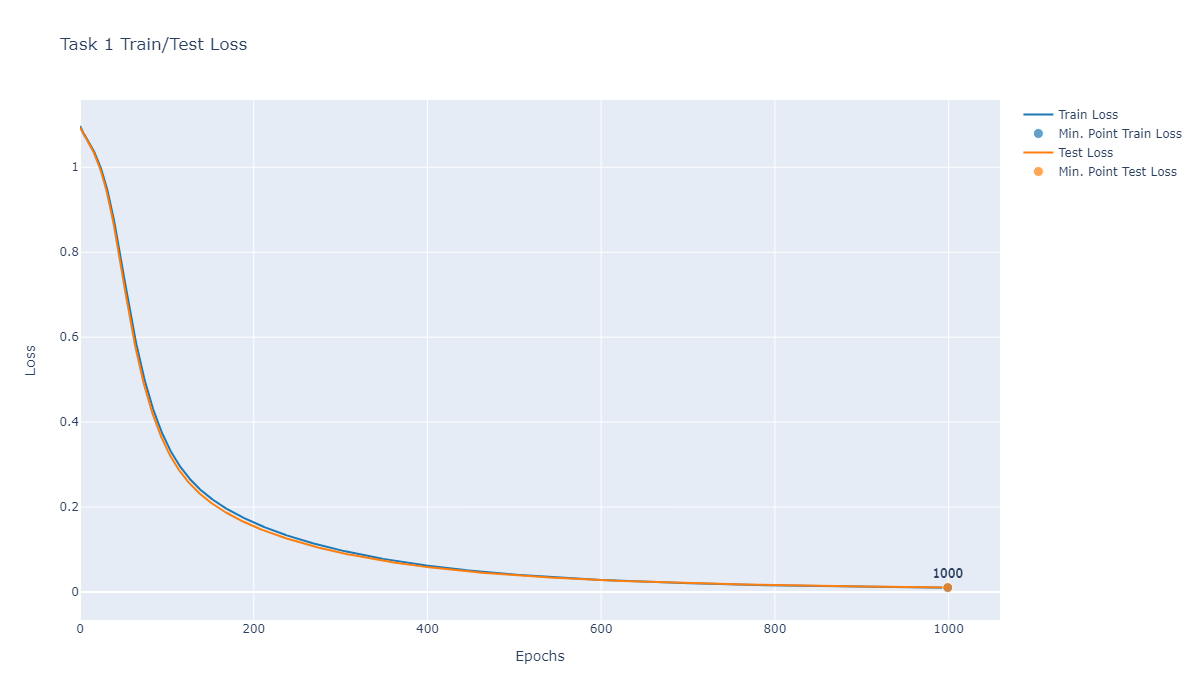

In [27]:
Image(image_bytes2)

As mentioned earlier, the 100% accuracy on both training and testing sets was investigated. With all bugs checked for,the next most obvious investigation was to check whether there was an overlap between training and testing data points. Both cells below tests this hypothesis, where the first cell checks the split dataframes, and the second checks individual tensors of both training and testing set.

Both investigations showed that there was no overlap of training and testing dataset.

In [28]:
# find any duplicates in the x_train and x_test dataframes
np.array([x for x in set(tuple(x) for x in x_train.values) & set(tuple(x) for x in x_test.values)])

array([], dtype=float64)

In [29]:
# find any duplicates in the test_data tensors and the train_data tensors
for test in tqdm(test_data):
    for train in train_data:
        if (test == train).all():
            print(test)
            break

100%|██████████| 886/886 [02:39<00:00,  5.56it/s]


# Task 2

Task 2 looks at reviewing how the architecture of a network, including the density of its layers affects the training outcome of a model.

For this assignment we deem a 3-layer neural network to be shallow, and a 12-layer neural network to be deep. Also, for wide neural network we ensure the density of hidden layers are at least 300 nodes, while for lean (the term we use as the opposite for wide) neural networks the maximum density of hidden layers are at most 5.

For this task, we used four different kinds of neural networks
1. Deep Lean Model: 12-Layer Feed-Forward Neural Network with nodes of 5, 5, 5, 4, 4, 4, 4, 3, 3, 3 for each hidden layer respectively.
2. Deep Wide Model: 12-Layer Feed-Forward Neural Network with nodes of 500, 500, 500, 400, 400, 400, 400, 300, 300, 300 for each hiddden layer respectively.
3. Shallow Lean Model: 3-Layer Feed-Forward Neural Network with nodes of 3 for each layer respectively.
4. Shallow Wide Model: 3-Layer Feed-Forward Neural Network with nodes of 500 for each hidden layer respectively  

The hyperparameters used were:
* Cross Entropy Loss
* 2000 epochs
* Stochastic Gradient Descent with Learning rate of 0.01 with no regularization or decay
* Batch size 200


In [55]:
reset_random_seeds()

deep_lean_model = twelve_layer_net(48, [5,5,5,5,4,4,4,4,3,3,3], 3)
deep_lean_model = deep_lean_model.to(device)

print(deep_lean_model)
display_num_param(deep_lean_model)

criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( deep_lean_model.to(device).parameters() , lr=0.1 )
bs = 200

history_deep_lean_model = fit(deep_lean_model, bs, num_epochs=2000, lr=0.01, decay=1, verbose=20)

twelve_layer_net(
  (layer1): Linear(in_features=48, out_features=5, bias=False)
  (layer2): Linear(in_features=5, out_features=5, bias=False)
  (layer3): Linear(in_features=5, out_features=5, bias=False)
  (layer4): Linear(in_features=5, out_features=5, bias=False)
  (layer5): Linear(in_features=5, out_features=4, bias=False)
  (layer6): Linear(in_features=4, out_features=4, bias=False)
  (layer7): Linear(in_features=4, out_features=4, bias=False)
  (layer8): Linear(in_features=4, out_features=4, bias=False)
  (layer9): Linear(in_features=4, out_features=3, bias=False)
  (layer10): Linear(in_features=3, out_features=3, bias=False)
  (layer11): Linear(in_features=3, out_features=3, bias=False)
  (layer12): Linear(in_features=3, out_features=3, bias=False)
)
There are 422 (0.00 million) parameters in this neural network
 Epoch 20, Training Error: 0.6601652882315896, Training Loss: 1.098612286827781, Test Error: 0.6572325706481934, Test Loss: 1.098612380027771, Time Elapsed: 0.0309116840

In [52]:
reset_random_seeds()

deep_wide_model = twelve_layer_net(48, [500]*4 + [400]*4 + [300]*4, 3)
deep_wide_model = deep_wide_model.to(device)

print(deep_wide_model)
display_num_param(deep_wide_model)


criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( deep_wide_model.to(device).parameters() , lr=0.01 )
bs = 200

history_deep_wide_model = fit(deep_wide_model, bs, num_epochs=2000, lr=0.01, decay=1, verbose=20)

twelve_layer_net(
  (layer1): Linear(in_features=48, out_features=500, bias=False)
  (layer2): Linear(in_features=500, out_features=500, bias=False)
  (layer3): Linear(in_features=500, out_features=500, bias=False)
  (layer4): Linear(in_features=500, out_features=500, bias=False)
  (layer5): Linear(in_features=500, out_features=400, bias=False)
  (layer6): Linear(in_features=400, out_features=400, bias=False)
  (layer7): Linear(in_features=400, out_features=400, bias=False)
  (layer8): Linear(in_features=400, out_features=400, bias=False)
  (layer9): Linear(in_features=400, out_features=300, bias=False)
  (layer10): Linear(in_features=300, out_features=300, bias=False)
  (layer11): Linear(in_features=300, out_features=300, bias=False)
  (layer12): Linear(in_features=300, out_features=3, bias=False)
)
There are 1754900 (1.75 million) parameters in this neural network
 Epoch 20, Training Error: 0.7038016644391146, Training Loss: 1.0986131646416404, Test Error: 0.7032093167304992, Test Lo

In [53]:
reset_random_seeds()

shallow_lean_model = three_layer_net(48, 4, 3, 3)
shallow_lean_model = shallow_lean_model.to(device)

print(shallow_lean_model)
display_num_param(shallow_lean_model)


criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( shallow_lean_model.to(device).parameters() , lr=0.01 )
bs = 200

history_shallow_lean_model = fit(shallow_lean_model, bs, num_epochs=2000, lr=0.01, decay=1, verbose=20)

three_layer_net(
  (layer1): Linear(in_features=48, out_features=4, bias=False)
  (layer2): Linear(in_features=4, out_features=3, bias=False)
  (layer3): Linear(in_features=3, out_features=3, bias=False)
)
There are 213 (0.00 million) parameters in this neural network
 Epoch 20, Training Error: 0.6314738284457814, Training Loss: 1.0828279581936924, Test Error: 0.6458837270736695, Test Loss: 1.0834231853485108, Time Elapsed: 0.01396942138671875
 Epoch 40, Training Error: 0.5732369477098639, Training Loss: 1.064452669837258, Test Error: 0.5543023467063903, Test Loss: 1.0645866632461547, Time Elapsed: 0.01796102523803711
 Epoch 60, Training Error: 0.6506198427893899, Training Loss: 1.0311125083403154, Test Error: 0.6429069876670838, Test Loss: 1.030606198310852, Time Elapsed: 0.014959573745727539
 Epoch 80, Training Error: 0.6601652882315896, Training Loss: 0.9788507168943231, Test Error: 0.6572325706481934, Test Loss: 0.9771213412284852, Time Elapsed: 0.017954111099243164
 Epoch 100, Tra

Based on the results below, we can determine and hypothesize the following.

Firstly, the lean networks performed poorer as compared to the wide networks. Generally, this behaviour can be expected as a previous experiment showed that a wide 16-layer network could outperform a 1000-layer deep network on the CIFAR dataset on ImageNet [[1](https://arxiv.org/pdf/1605.07146.pdf)]. Also, having wider networks allows the the model to better learn the patterns of the data, while having a deeper network should theoretically help it to generalize better. While this may seem to imply that the best models are both wide and deep, it may not be the case. As our dataset has been shown to be relatively easy to predict, we have shown that a fairly wide but shallow network is able to achieve 100% training and testing accuracy in Task 1. As such, adding more layers only adds noise the network and ultimately resulted in the Deep and Wide network to perform poorer as compared to the Wide and Shallow network. Ultimately, these hyperparameters and architectures are entirely dependent on the problem statement at hand, and for ours we do not need deep networks.

The point made above segues to the next observation that shallow networks performed better than their deeper counterparts. As a matter of fact, the lean and deep model was completely unable to learn anthing in the first 2,000 epochs. As mentioned before, this does not come as a  surprise since the dataset is relatively easy to predict. As such, adding more layers on top of a shallow network that could achieve a 100% accuracy already only adds unnecessary noise to the network [[2](https://arxiv.org/pdf/1512.03385.pdf)].

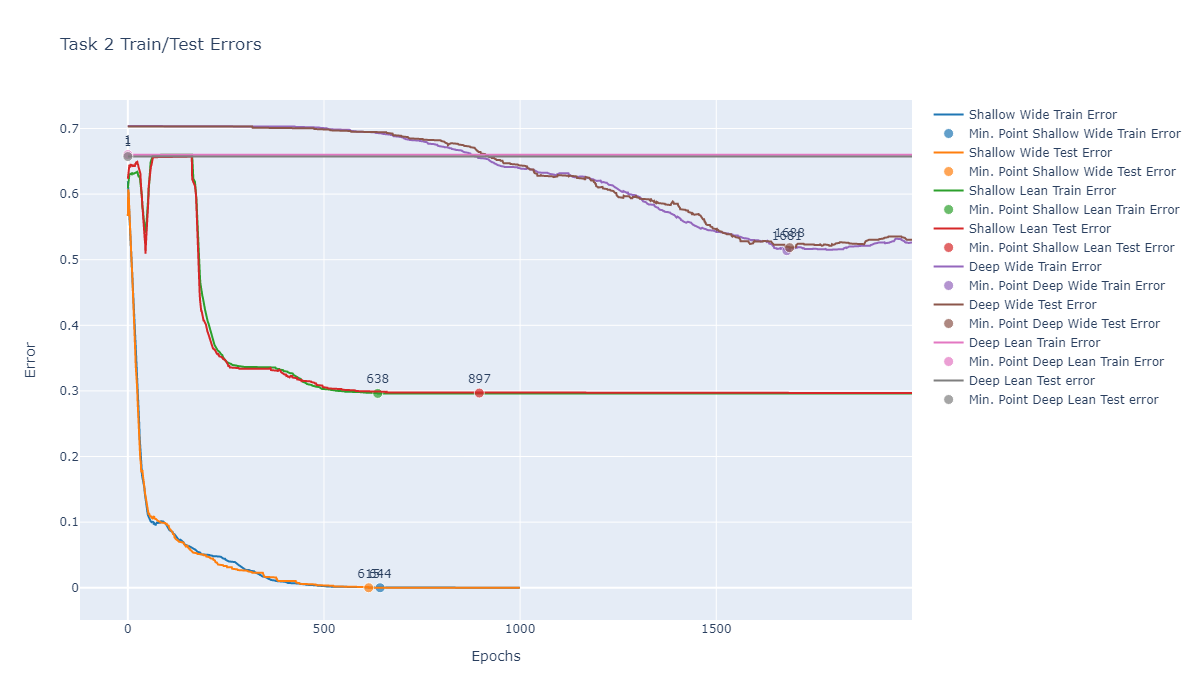

In [77]:
fig3 = plot_line('Task 2 Train/Test Errors', 'Error', 'Epochs', 
                    Shallow_Wide_Train_Error=history['train_error'], Shallow_Wide_Test_Error=history['test_error'], 
                    Shallow_Lean_Train_Error=history_shallow_lean_model['train_error'], Shallow_Lean_Test_Error=history_shallow_lean_model['test_error'],
                    Deep_Wide_Train_Error=history_deep_wide_model['train_error'], Deep_Wide_Test_Error=history_deep_wide_model['test_error'],
                    Deep_Lean_Train_Error=history_deep_lean_model['train_error'], Deep_Lean_Test_error=history_deep_lean_model['test_error'])
image_bytes3 = fig3.to_image(format='png', width=1200, height=700, scale=1)
Image(image_bytes3)

# Task 3

Task 3 looks at reviewing how the learning rates, as well as decay and increments can affect the training outcome of a model. For this section, we split our investigations into two parts:

1. Training the network from Task 1 with different learning rates and no decay/increments.
2. Training the network from Task 1 with a learning rate of 0.5 and different rates of decay/increments.

The hyperparameters for the networks trained are detailed as such:
1. 3-Layer Neural Network
2. 500 nodes per hidden layer
3. Cross Entropy Loss
4. 1000 epochs
5. Varied learning rates with no regularization or decay
6. Batch size 200

In the first part, we used different learning rates of 0.01, 0.05, 0.1, 0.5 and 1. 

In [58]:
# Try different learning rates
# 0.01, 0.05, 0.1, 0.5, 1
task3_histories = {}
bs = 200

for lr in [0.01, 0.05, 0.1, 0.5, 1]:
    task3_network = three_layer_net(48,500,500,3)
    task3_network = task3_network.to(device)
    criterion = nn.CrossEntropyLoss()
    task3_histories[str(lr)] = fit(task3_network, bs, num_epochs=1000, lr=lr, decay=1, verbose=20)


 Epoch 20, Training Error: 0.385798914866014, Training Loss: 1.0284860025752673, Test Error: 0.372069776058197, Test Loss: 1.024229645729065, Time Elapsed: 0.017927169799804688
 Epoch 40, Training Error: 0.15331956473263827, Training Loss: 0.8919440453702753, Test Error: 0.1355814218521118, Test Loss: 0.8806692481040954, Time Elapsed: 0.01895761489868164
 Epoch 60, Training Error: 0.09870525923642245, Training Loss: 0.6618198914961382, Test Error: 0.09560467004776001, Test Loss: 0.6441130876541138, Time Elapsed: 0.01864767074584961
 Epoch 80, Training Error: 0.0959917577830228, Training Loss: 0.47439676794138824, Test Error: 0.09360467195510865, Test Loss: 0.45658103823661805, Time Elapsed: 0.020943403244018555
 Epoch 100, Training Error: 0.09508266232230446, Training Loss: 0.3589796938679435, Test Error: 0.08927909135818482, Test Loss: 0.342459237575531, Time Elapsed: 0.01929926872253418
 Epoch 120, Training Error: 0.08688707785172896, Training Loss: 0.28872941027988086, Test Error: 0

The figure below shows the results. By determining the performance of a learning rate by how quickly the network converges and/or reach 100% accuracy, we can make the following observations.

Firstly, a learning rate of 0.1 outperformed all other learning rates. Secondly, a learning rate of 1 performed the worst.

Both observations can be explained as a result of finding the optimal learning rate. A high learning rate implies a model is very quickly able to converge, although it may miss the global minima and fall into a local minima or even diverge entirely and achieve at best random guesses (i.e. similar too how a learning rate of 0.5 and 1 performed).

On the other hand, having a low learning rate can result in the model taking a longer time to converge. This is why a learning rate of 0.05 took a longer time to converge when compared to a learning rate of 0.1, and a learning rate of 0.01 took a longer time to converge when compared to a learning rate of 0.05. However, all three learning rates (0.01, 0.05, 0.1) eventually reached maximum accuracy.

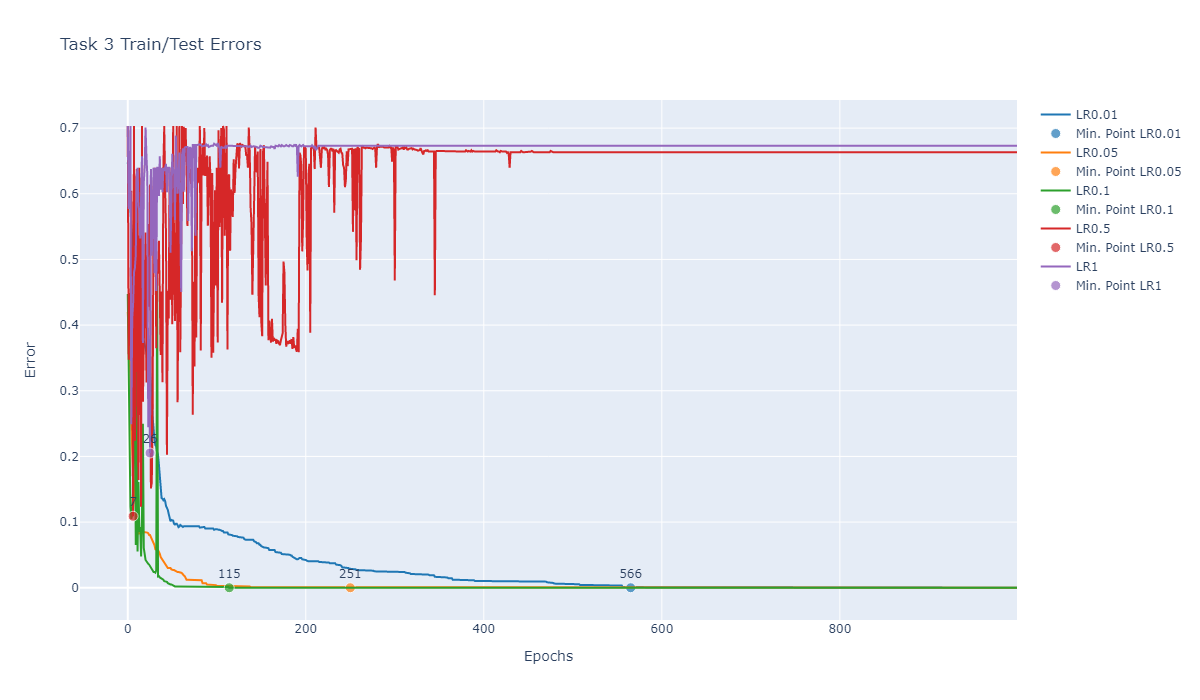

In [78]:
fig4 = plot_line('Task 3 Train/Test Errors', 'Error', 'Epochs', decimal=True,
                LR0_01=task3_histories['0.01']['test_error'],
                LR0_05=task3_histories['0.05']['test_error'],
                LR0_1=task3_histories['0.1']['test_error'],
                LR0_5=task3_histories['0.5']['test_error'],
                LR1=task3_histories['1']['test_error'],) 
image_bytes4 = fig4.to_image(format='png', width=1200, height=700, scale=1) 

Image(image_bytes4)

Next, we decided to use the poorly performing learning rate of 0.5 and adjusted its learning rate every 20 epochs. In general, every 20 epochs we tried multiplying the learning rate by:
* 0.1
* 0.5
* 1 (Same as Task 3's first part)
* 1.5
* 2

The hypothesis is that a learning rate of 0.5 performed poorly because it could not converge due to the large steps taken in each epoch. As such, a multiplication of >=1 per epoch will only degrade its performance, while a multiplication of <1 will result in gradual decrease in learning rate and a higher likelihood of convergence. It is to be expected that the greater the decay, the better the model should perform.

In [83]:
# Try different decay rates
# 0.1, 0.5, 1, 1.5, 2
task3b_histories = {}
bs = 200

for decay in [0.1, 0.5, 1, 1.5, 2]:
    task4_network = three_layer_net(48,500,500,3)
    task4_network = task4_network.to(device)
    criterion = nn.CrossEntropyLoss()
    task3b_histories[str(decay)] = fit(task4_network, bs, num_epochs=1000, lr=0.5, decay=decay, verbose=20)

 Epoch 20, Training Error: 0.5981404943899675, Training Loss: 1.135068947618658, Test Error: 0.41139534711837766, Test Loss: 0.9001535654067994, Time Elapsed: 0.01894831657409668
 Epoch 40, Training Error: 0.04183197563344782, Training Loss: 0.14960664239796725, Test Error: 0.03630235195159912, Test Loss: 0.14313157200813292, Time Elapsed: 0.018957138061523438
 Epoch 60, Training Error: 0.04046833515167236, Training Loss: 0.13546438244256107, Test Error: 0.03362793922424316, Test Loss: 0.1315183684229851, Time Elapsed: 0.02593088150024414
 Epoch 80, Training Error: 0.039559245109558105, Training Loss: 0.13412148708646948, Test Error: 0.03362793922424316, Test Loss: 0.1306277334690094, Time Elapsed: 0.021939516067504883
 Epoch 100, Training Error: 0.039559245109558105, Training Loss: 0.13398756764151834, Test Error: 0.03362793922424316, Test Loss: 0.13053784817457198, Time Elapsed: 0.017918109893798828
 Epoch 120, Training Error: 0.039559245109558105, Training Loss: 0.13397425006736408,

Based on the figure below, we can conclude that our hypothesis was correct. In all three cases where the learning rate was multiplied by a value >=1, we found that they performed poorly and was unable to learn anything beyond random guessing. More importantly, the higher the value multiplied, the poorer it performed (i.e. quickly converged to random guessing).

We also noticed that the network performed better the greater the decay rate was (i.e. the smaller the number multiplied). This is to be expected as we'd previously determined the ideal (fixed) learning rate to be at around 0.1.

While not immediately apparent in these experiments as a result of how simple the dataset is, the decay rate is also a popular strategy for preventing overfitting. By reducing the learning rate, we can enable the network to take smaller steps that might allow the network to reach closer to the current minima it is in. As it stands right now, the model has shown to not be overfitting even past 2,000 epochs.

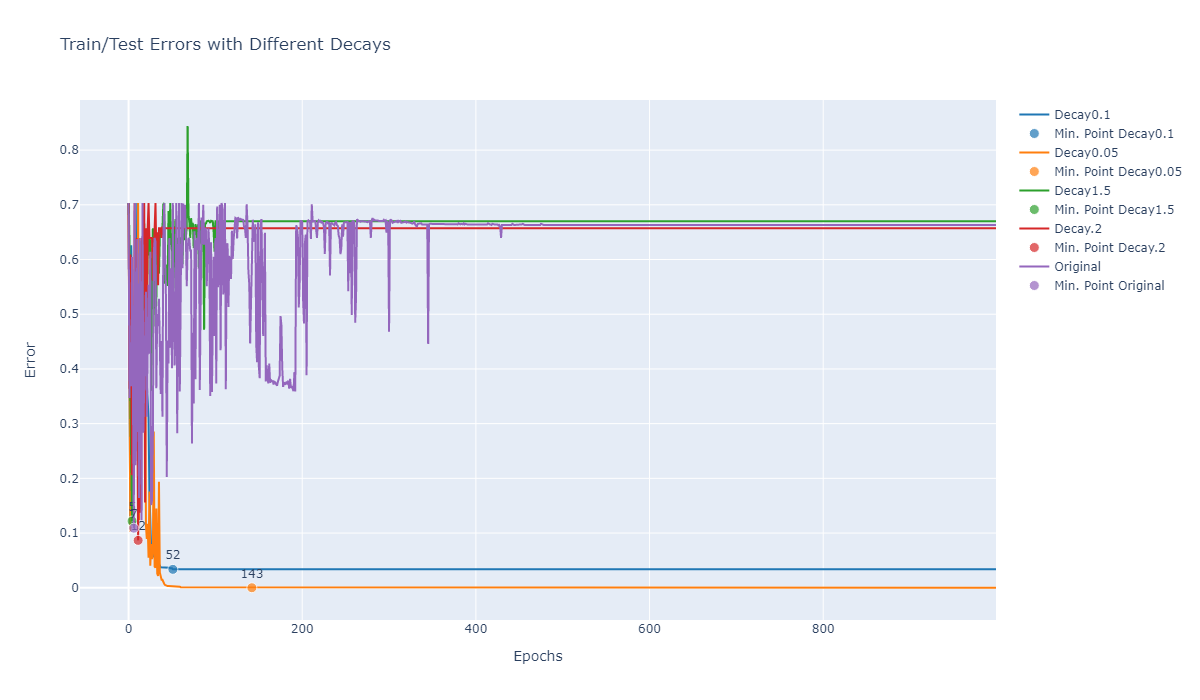

In [84]:
fig4b = plot_line('Train/Test Errors with Different Decays', 'Error', 'Epochs', decimal=True,
                Decay0_1=task3b_histories['0.1']['test_error'],
                Decay0_05=task3b_histories['0.5']['test_error'],
                Decay1_5=task3b_histories['1.5']['test_error'],
                Decay_2=task3b_histories['2']['test_error'],
                Original=task3_histories['0.5']['test_error']) 
image_bytes4b = fig4b.to_image(format='png', width=1200, height=700, scale=1) 

Image(image_bytes4b)

# Task 4

Task 4 looks at reviewing how the batch sizes affects the training outcome of a model. More importantly, we would like to investigate the following:
* Stochastic Gradient Descent (batch size = 1)
* Mini-Batch Gradient Descent (batch size > 1, batch size < total data points)
* Batch Gradient Descent (batch size = total data points)

For this task, we trained the same model as Task 1's over 650 epochs for the following batch sizes:
* 1
* 200
* 500
* 1000
* 1500
* 2066 (size of training data)

The batch size of 1 was only trained for 20 epochs due to the high amount of time needed.

In [65]:
task4_histories = {}

for bs in [1, 200, 500, 1000, 1500, 2066]:
    task4_network = three_layer_net(48,500,500,3)
    task4_network = task4_network.to(device)

    criterion = nn.CrossEntropyLoss()
    task4_histories[str(bs)] = fit(task4_network, bs, num_epochs=650 if bs!= 1 else 20, lr=0.01, decay=1, verbose=20)


 Epoch 20, Training Error: 0.0, Training Loss: 0.0009762841136492896, Test Error: 0.0, Test Loss: 0.001265767471741177, Time Elapsed: 3.0872578620910645
 Epoch 20, Training Error: 0.3271487680348483, Training Loss: 1.0261664932424372, Test Error: 0.31044186353683473, Test Loss: 1.0204513549804688, Time Elapsed: 0.01994633674621582
 Epoch 40, Training Error: 0.18203857812014493, Training Loss: 0.8880728049711748, Test Error: 0.16858140230178834, Test Loss: 0.8738118171691894, Time Elapsed: 0.017947673797607422
 Epoch 60, Training Error: 0.09692839600823143, Training Loss: 0.656206033446572, Test Error: 0.10060466527938842, Test Loss: 0.6361006736755371, Time Elapsed: 0.01895594596862793
 Epoch 80, Training Error: 0.0805372108112682, Training Loss: 0.46487086469476874, Test Error: 0.07827908992767334, Test Loss: 0.4464869797229767, Time Elapsed: 0.021941423416137695
 Epoch 100, Training Error: 0.07097797502170909, Training Loss: 0.34814087369225244, Test Error: 0.06695349216461181, Test 

From our experiment we see that Batch Gradient Descent performed the worst and Stochastic Gradient Descent performed the best. Generally, it appears that the larger the batch size, the poorer the training of the network (i.e. either lower accuracy, or longer time to converge).

We hypothesize that updating the weights in small batches allows for several benefits over Batch Gradient Descent.

Firstly (and most obviously) batch gradient descent can be more computationally expensive as compared to mini-batch gradient descent or stochastic gradient descent for huge datasets. This is not true in our case as our training dataset only has 99,168 data points (i.e. 2066 x 48 = 99,168), which can be considered to be very small by modern standards.

Secondly, smaller batches allows for reduced noise from outliers or biases. By sampling the dataset in small batches, we effectively have a lower likelihood of sampling many noisy dataset at once, thus getting a better estimate of the true data distribution better at the end of each epoch.

Finally, using smaller batches allows us to perform gradient descent several times in a single epoch. This allows for better generalization on the model as we are able to reach a minima quicker in every epoch.

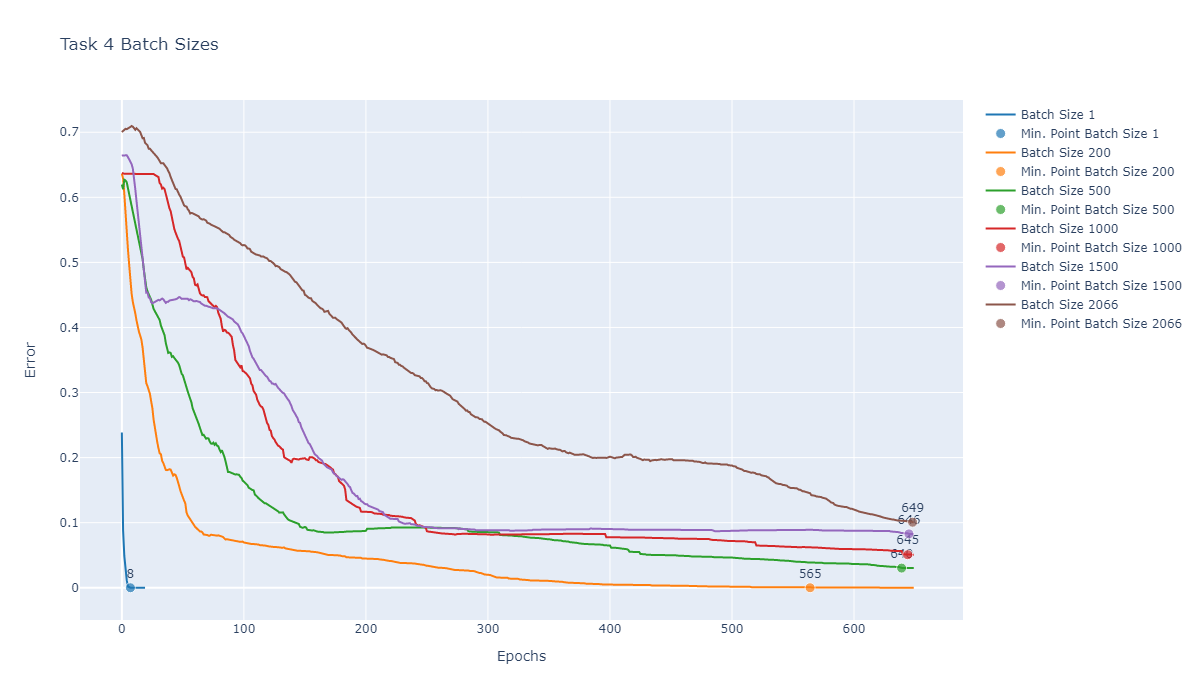

In [66]:
fig5 = plot_line('Task 4 Batch Sizes', 'Error', 'Epochs',
                Batch_Size_1=task4_histories['1']['test_error'],
                Batch_Size_200=task4_histories['200']['test_error'],
                Batch_Size_500=task4_histories['500']['test_error'],
                Batch_Size_1000=task4_histories['1000']['test_error'],
                Batch_Size_1500=task4_histories['1500']['test_error'],
                Batch_Size_2066=task4_histories['2066']['test_error']) 
image_bytes5 = fig5.to_image(format='png', width=1200, height=700, scale=1) 

Image(image_bytes5)

In our case, as the dataset is relatively small we lost computation time the smaller the batch size was. This is because we could easily fit the entire training data in our GPU VRAM.

In [88]:
print(f"Average Time Taken per Epoch:")
print(f"Batch Size 1: {sum(task4_histories['1']['time'])/20}")
print(f"Batch Size 200: {sum(task4_histories['200']['time'])/650}")
print(f"Batch Size 500: {sum(task4_histories['500']['time'])/650}")
print(f"Batch Size 1000: {sum(task4_histories['1000']['time'])/650}")
print(f"Batch Size 1500: {sum(task4_histories['1500']['time'])/650}")
print(f"Batch Size 2066: {sum(task4_histories['2066']['time'])/650}")



Average Time Taken per Epoch:
Batch Size 1: 3.260171389579773
Batch Size 200: 0.019703899897061863
Batch Size 500: 0.009243349295396072
Batch Size 1000: 0.0063370502912081204
Batch Size 1500: 0.004900661248427171
Batch Size 2066: 0.0037369016500619742
